In [1]:
import requests
import networkx as nx 
from plotly import graph_objects as go

In [42]:
import numpy as np

In [98]:
def visualize_network(G, color_by = None, size_by = None, title = None, layout = "spring_layout", size_scale=10):
    """
      Layouts: [graphviz_layout, pydot_layout, bipartite_layout, circular_layout, kamada_kawai_layout, planar_layout, random_layout, rescale_layout,
                spring_layout, spectral_layout, spiral_layout, multipartite_layout] 
      Size_by: "color_by", None, List or "node_attribute" in G.nodes(data=True)
    """
    if title is None:
        title = "Plotly Networkx visualization"
    if color_by not in set(G.nodes(data=True)[list(G.nodes.keys())[0]].keys()) and color_by is not None:
        raise Exception("Attribute Error: '{}' not found in nodes attributes".format(color_by))
    else:
        if size_by == "color_by":
            size_by = color_by 
    if layout is not None:
        if layout == "graphviz_layout":
            pos = nx.nx_pydot.graphviz_layout(G)
        elif layout == "pydot_layout":
            pos = nx.nx_pydot.pydot_layout(G)
        elif layout == "bipartite_layout":
            top = nx.bipartite.sets(G)[0]
            pos = nx.bipartite_layout(G, top)
        elif layout == "circular_layout":
            pos = nx.circular_layout(G)
        elif layout == "kamada_kawai_layout":
            pos = nx.kamada_kawai_layout(G)
        elif layout == "planar_layout":
            pos = nx.planar_layout(G)
        elif layout == "random_layout":
            pos = nx.random_layout(G)
        elif layout == "rescale_layout":
            pos = nx.rescale_layout(G)
        elif layout == "spring_layout":
            pos = nx.spring_layout(G)
        elif layout == "spectral_layout":
            pos = nx.spectral_layout(G)
        elif layout == "spiral_layout":
            pos = nx.spiral_layout(G)
        elif layout == "multipartite_layout":
            pos = nx.multipartite_layout(G)
        elif isinstance(layout, dict):
            pos = layout

        nx.set_node_attributes(G, pos, "pos")

    edge_x = []
    edge_y = []
    edge_text = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        edge_text.append("Edge {} - {}".format(edge[0], edge[1]))

    edge_trace = go.Scatter(
                                  x=edge_x, y=edge_y,
                                  line=dict(width=0.5, color='white'),
                                  hoverinfo='text',
                                  text=edge_text,
                                  mode='lines'
                            )

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
                               x=node_x, y=node_y,
                                mode= 'markers',
                                hoverinfo="name+text",
                                marker = dict(
                                  showscale=True,
                                  #colorscale options
                                  #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                                  #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                                  #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                                  colorscale='Blues',
                                  reversescale=True,
                                  color=[],
                                  size=10,
                                  colorbar=dict(
                                    thickness=15,
                                    title=color_by,
                                    xanchor='left',
                                    titleside='right'
                                  ),
                                  line_width=2
                               )
                            )

    if color_by is not None:
        node_color = []
        node_size = []
        for node, attributes in G.nodes(data=True):
            value = attributes[color_by]
            node_color.append(value)
            if isinstance(value, str):
                colors_str = [elem[color_by] for elem in list(dict(G.nodes(data=True)).values())]
                map_size_with_color = {elem: i+1 for i, elem in enumerate(np.unique(colors_str))}
                value = map_size_with_color[value]

            if size_by is not None:
                size = value*size_scale
            node_size.append(size)
        node_trace.marker.color = node_color
        if size_by is not None:
            node_trace.marker.size = node_size

    nodes_text = []
    for node, attributes in G.nodes(data=True):
        node_text = "Node: {}\n\n".format(node)
        for attribute_name, value in dict(attributes).items():
            node_text += "{}: {}\n".format(attribute_name, value)
        nodes_text.append(node_text)
    node_trace.text = nodes_text

    fig = go.Figure(data=[edge_trace, node_trace],
                      layout=go.Layout(
                      title=title,
                      titlefont_size=16,
                      showlegend= False,
                      hovermode='closest',
                      margin=dict(b=20,l=5,r=5,t=40),
                      xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                      yaxis=dict(showgrid=False, zeroline=False, showticklabels=False), 
                      template="plotly_dark"
                      ),
    )
    return fig

In [83]:
def request_protein_interactions_network(gene_names, threshold=0.4):
    
    string_api_url = "https://version-11-5.string-db.org/api"
    output_format = "tsv-no-header"
    method = "network"
    request_url = "/".join([string_api_url, output_format, method])
    
    params = {

        "identifiers" : "%0d".join(gene_names), # your protein
        "species" : 9606, # species NCBI identifier 
         #"caller_identity" : "test_for_now" # your app name

    }

    response = requests.post(request_url, data=params)
    edgelist = []
    weights = {}
    for line in response.text.strip().split("\n"):

        l = line.strip().split("\t")
        p1, p2 = l[2], l[3]

        ## filter the interaction according to experimental score
        experimental_score = float(l[10])
        if experimental_score > threshold:

            #print("\t".join([p1, p2, "experimentally confirmed (prob. %.3f)" % experimental_score])) 
            edgelist.append([p1, p2])
            weights[(p1, p2)] = experimental_score
            
    G = nx.from_edgelist(edgelist)
    
    for (n1, n2), weight in weights.items():
        G[n1][n2]['weight'] = weight
    return G

In [57]:
protein_list = ["TP53"]
G = request_protein_interactions_network(protein_list)

In [58]:
G.nodes(data=True), G.edges(data=True)

(NodeDataView({'SIRT1': {}, 'EP300': {}, 'TP53': {}, 'AURKA': {}, 'DDX5': {}, 'UBE3A': {}, 'RPA1': {}, 'CDK2': {}, 'MDM2': {}, 'CREBBP': {}, 'BARD1': {}}),
 EdgeDataView([('SIRT1', 'EP300', {'weight': 0.733}), ('SIRT1', 'TP53', {'weight': 0.884}), ('EP300', 'DDX5', {'weight': 0.7}), ('EP300', 'MDM2', {'weight': 0.874}), ('EP300', 'CREBBP', {'weight': 0.805}), ('EP300', 'CDK2', {'weight': 0.757}), ('EP300', 'TP53', {'weight': 0.998}), ('TP53', 'AURKA', {'weight': 0.875}), ('TP53', 'DDX5', {'weight': 0.748}), ('TP53', 'UBE3A', {'weight': 0.919}), ('TP53', 'RPA1', {'weight': 0.973}), ('TP53', 'MDM2', {'weight': 0.998}), ('TP53', 'BARD1', {'weight': 0.848}), ('TP53', 'CREBBP', {'weight': 0.983}), ('TP53', 'CDK2', {'weight': 0.79}), ('RPA1', 'CDK2', {'weight': 0.506}), ('CDK2', 'CREBBP', {'weight': 0.758}), ('MDM2', 'CREBBP', {'weight': 0.866})]))

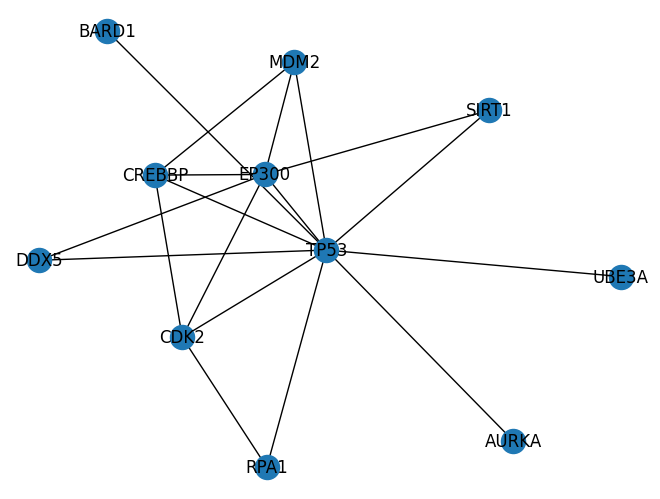

In [110]:
import matplotlib.pyplot as plt
fig = plt.figure()
nx.draw(G, with_labels=True)

In [111]:
fig.savefig("{}_PPI_nx_networkx.png".format(protein_list[0]), format="PNG")

In [60]:
node_colors = {node: ("green" if node in protein_list else "blue") for node in G.nodes}
nx.set_node_attributes(G, node_colors, "color")
G.nodes(data=True)

NodeDataView({'SIRT1': {'color': 'blue'}, 'EP300': {'color': 'blue'}, 'TP53': {'color': 'green'}, 'AURKA': {'color': 'blue'}, 'DDX5': {'color': 'blue'}, 'UBE3A': {'color': 'blue'}, 'RPA1': {'color': 'blue'}, 'CDK2': {'color': 'blue'}, 'MDM2': {'color': 'blue'}, 'CREBBP': {'color': 'blue'}, 'BARD1': {'color': 'blue'}})

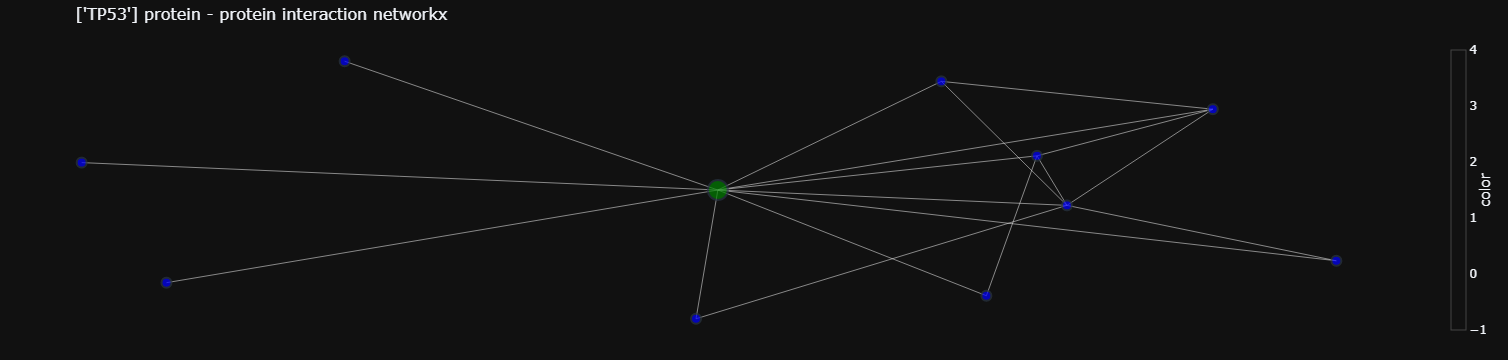

In [99]:
fig = visualize_network(G, color_by = 'color', size_by = 'color', title = "{} protein - protein interaction networkx".format(protein_list), layout = "spring_layout")#color = None Problem

In [100]:
fig.write_html("{}_PPI_networkx.html".format(protein_list[0]))

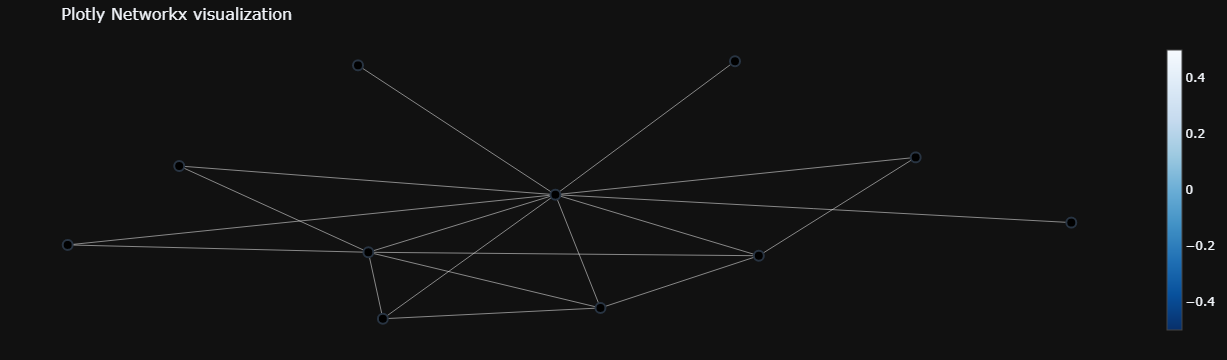

In [93]:
visualize_network(G, color_by = None, size_by = None, title = None, layout = "spring_layout")

In [ ]:
def get_all_ensp():
    all_ensp = #pass
    return all_ensp